# Perfs

## Import de la recherche

In [ ]:
from typing import Callable, List, Dict
from index import Document, Corpus, InvertedIndex, Query

import pandas, os, re

DATA_FOLDER = os.path.join(os.getcwd(), "output")

XML_INITIAL_FILE = os.path.join(DATA_FOLDER, "corpus_initial.xml")
STEMMED_REPLACEMENTS = os.path.join(DATA_FOLDER, "stemmed_replacement.tsv")
LEMMATIZED_REPLACEMENTS = os.path.join(DATA_FOLDER, "lemmatized_replacement.tsv")

TEXTE_INDEX_FILE = os.path.join(DATA_FOLDER, "index_files", "texte_index.xml")
LEGENDE_INDEX_FILE = os.path.join(DATA_FOLDER, "index_files", "legende_index.xml")
TITRE_INDEX_FILE = os.path.join(DATA_FOLDER, "index_files", "titre_index.xml")

STORAGE_TAGS = {"Corpus": "corpus", "documents": "bulletins", "Document": "bulletin", "Image": "image"}

STANDARDIZE: Callable[[str], str] = lambda x: re.sub(r"[^\w\s]", "", re.sub(r"'", " ", x.strip().lower()))

In [55]:
# 1. Charge le Corpus
with open(XML_INITIAL_FILE, "r", encoding="utf-8") as f:
    CORPUS = Corpus.model_validate_xml(f.read(), tags=STORAGE_TAGS)

# 2. Charge l'Index inversé par zone    
INDEX = {}
for zone, file in zip(["texte", "legendes", "titre"], [TEXTE_INDEX_FILE, LEGENDE_INDEX_FILE, TITRE_INDEX_FILE]):
    INDEX[zone] = InvertedIndex.from_dataframe(pandas.read_csv(file, sep="\t", encoding="utf-8"))
    
# 3. Charge le dictionnaire de lemmatisation
substitutions_df = pandas.read_csv(STEMMED_REPLACEMENTS, sep="\t", header=None, na_filter=False)
substitutions = {inp: repl for inp, repl in zip(substitutions_df.iloc[:,0], substitutions_df.iloc[:,1])}
TOKENIZE: Callable[[List[str]], List[str]] = lambda x: [substitutions.get(STANDARDIZE(token), STANDARDIZE(token)) for token in x]

# 4. Défini la search function (et l'application de la lemmatisation)
def search(s: str) -> List[Document]:
    q = Query.build(
        'montre moi les articles qui parlent de environnement minimum depuis juillet 2011 et qui nest pas dans la rubrique Focus',
    )
    for field in ["keywords", "excluded_keywords", "title_contains"]:
        setattr(q, field, TOKENIZE(getattr(q, field)))
    for field in ["rubriques", "excluded_rubriques"]:
        setattr(q, field, [STANDARDIZE(r) for r in getattr(q, field)])
    return q.search(documents=CORPUS, index=INDEX)

In [57]:
result = search("Documents qui parlent d'environnement")
result

[Document(fichier='67794.htm', numero='261', date=datetime.datetime(2011, 9, 29, 0, 0), rubrique='Focus', titre="9 milliards d'hommes à nourrir : un défi majeur !", auteur='ADIT - Jean-François Desessard - email : jfd@adit.fr', contact='François Bourin Editeur - www.bourin-editeur.fr', texte='C\'est sans doute pour l\'humanité le défi majeur de ces 40 prochaines années. D\'ici 2050, alors que la Terre comptera environ 9 milliards d\'êtres humains, iil faudra en effet réussir à produire en quantité croissante une nourriture répondant à des normes de qualité exigeantes, ceci en respectant mieux l\'environnement. D\'où le titre de l\'ouvrage co-écrit par Marion Guillou, Présidente de l\'Institut National de la Recherche Agronomique (INRA), et Gérard Matheron, Président du Centre de coopération Internationale en Recherche Agronomique pour le Développement (CIRAD), et publié par François Bourin Editeur. Confronté à cet extraordinaire défi, l\'homme peut éviter un cataclysme selon les auteur

In [59]:
[r.document_id for r in result]

['67794.htm', '67389.htm', '67385.htm']

## Evaluation des Performances

In [44]:
TRUTH: Dict[str, List[Document]] = {
    "this is a set of queries": ["123"],
    "mapped to the documents that": ["456"],
    "should be retrieved": ["123", "456"],
} # TODO : Récupérer les exemples de recherche de Raphael

### Fonction statistique

In [61]:
resulting_docs: Callable[[str], List[Document]] = lambda x: ["123"]  # lambda x: [d.document_id for d in search(x)]

### Calcul des métriques

In [62]:
import pandas as pd

DATA = pd.DataFrame(columns=["Recall", "Precision", "Delay", "Hint"])

for query, truth in TRUTH.items():
    results = resulting_docs(query)

    row = {
        "Recall":    len(set(results) & set(truth)) / len(truth),
        "Precision": len(set(results) & set(truth)) / len(results),
        "Delay":     0,
        "Hint":      query,
    }

    DATA = pd.concat([DATA, pd.DataFrame([row])], ignore_index=True)

DATA

C:\Users\ongki\AppData\Local\Temp\ipykernel_11980\3171210285.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DATA = pd.concat([DATA, pd.DataFrame([row])], ignore_index=True)


,Recall,Precision,Delay,Hint
0,1.0,1.0,0,this is a set of queries
1,0.0,0.0,0,mapped to the documents that
2,0.5,1.0,0,should be retrieved


### Visualisation

In [69]:
df = DATA.melt(
    value_vars=["Recall","Precision","Delay"],
    var_name="Metric",
    value_name="Score"
)
df.head(2)

,Metric,Score
0,Recall,1.0
1,Recall,0.0


<Axes: xlabel='Metric', ylabel='Score'>

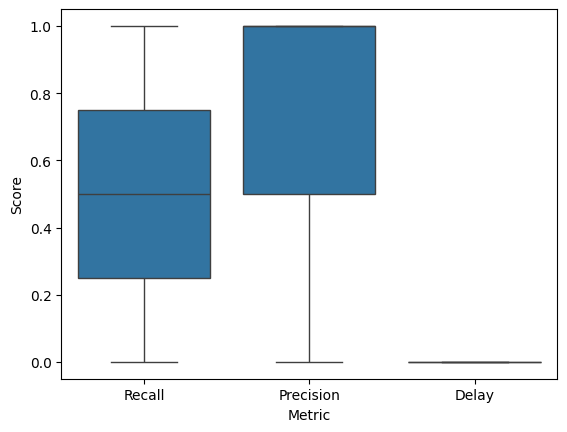

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplots of the metrics
sns.boxplot(x="Metric", y="Score", data=df)

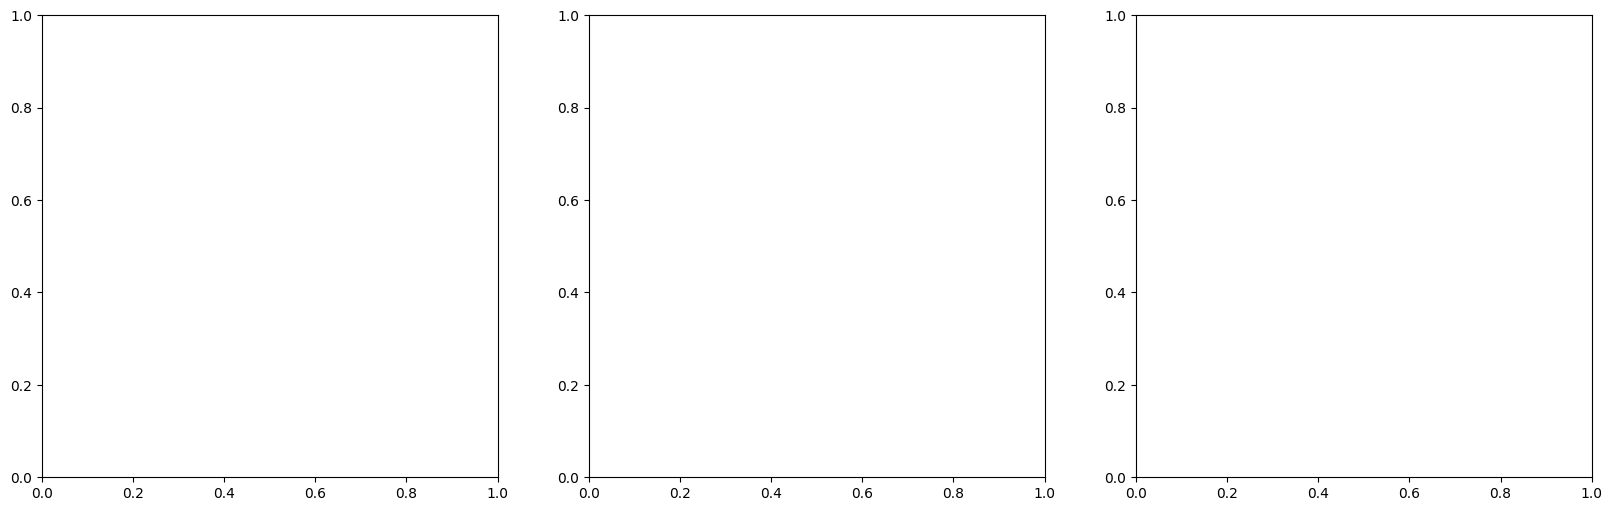

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot using complexity / length of the query (nuage de points qui forme une espèce de courbe)

# Plot with lemmatizer or with stemmer (have to change the recording function) (deux boxplots)

# Plot with extra tokenization and without extra tokenization (reposer sur le corpus ou plus)
